# Transfer Learning with TensorFlow Part 2: Fine-tuning

In **fine-tuning transfer learning** the pre-trained model weights from another model are unfrozen and tweaked during to better suit your own data.

For feature extraction transfer learning, you may only train the top 1-3 layers of a pre-trained model with your own data, in fine-tuning transfer learning, you might train 1-3+ layers of a pre-trained model (where the '+' indicates that many or all of the layers could be trained).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-transfer-learning-feature-extraction-vs-fine-tuning.png)
*Feature extraction transfer learning vs. fine-tuning transfer learning. The main difference between the two is that in fine-tuning, more layers of the pre-trained model get unfrozen and tuned on custom data. This fine-tuning usually takes more data than feature extraction to be effective.*

## What we're going to cover

- Introduce fine-tuning, a type of transfer learning to modify a pre-trained model to be more suited to your data
- Using the Keras Functional API (a differnt way to build models in Keras)
- Using a smaller dataset to experiment faster (e.g. 1-10% of training samples of 10 classes of food)
- Data augmentation (how to make your training dataset more diverse without adding more data)
- Running a series of modelling experiments on our Food Vision data
  - Model 0: a transfer learning model using the Keras Functional API
  - Model 1: a feature extraction transfer learning model on 1% of the data with data augmentation
  - Model 2: a feature extraction transfer learning model on 10% of the data with data augmentation
  - Model 3: a fine-tuned transfer learning model on 10% of the data
  - Model 4: a fine-tuned transfer learning model on 100% of the data
- Introduce the ModelCheckpoint callback to save intermediate training results
- Compare model experiments results using TensorBoard


In [1]:
# Are we using a GPU? (if not & you're using Google Colab, go to Runtime -> Change Runtime Type -> Harware Accelerator: GPU )
!nvidia-smi

Tue Aug  9 01:37:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

Throughout your machine learning experiments, you'll likely come across snippets of code you want to use over and over again.

But as you might've guessed, rewritting the same functions becomes tedious.

One of the solutions is to store them in a helper script such as [`helper_functions.py`](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py). And then import the necesary functionality when you need it.

In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2022-08-09 01:37:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-09 01:37:14 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete the `helper_functions.py` file. So to use the functions imported above, you'll have to rerun the cell.

## 10 Food Classes: Working with less data

We saw in the [previous notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb) that we could get great results with only 10% of the training data using transfer learning with TensorFlow Hub. For this notebook we'll:

* Use the in-built pretrained models within the `tf.keras.applications` module as well as how to fine-tune them to our own custom dataset.

* Practice using a new but similar dataloader function to what we've used before, [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) which is part of the [`tf.keras.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing) module.

* Practice using the [Keras Functional API](https://keras.io/guides/functional_api/) for building deep learning models. The Functional API is a more flexible way to create models than the tf.keras.Sequential API.



In [3]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2022-08-09 01:37:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   111MB/s    in 1.5s    

2022-08-09 01:37:26 (111 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



The dataset we're downloading is the 10 food classes dataset (from Food 101) with 10% of the training images we used in the previous notebook.

> 🔑 **Note:** You can see how this dataset was created in the [image data modification notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).



In [4]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

We can see that each of the training directories contain 75 images and each of the testing directories contain 250 images.

Let's define our training and test filepaths.

In [5]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) class. And while this works well and is still very commonly used, this time we're going to use the `image_data_from_directory` function.

It works much the same way as `ImageDataGenerator`'s `flow_from_directory` method meaning your images need to be in the following file format:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

One of the main benefits of using [`tf.keras.prepreprocessing.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) rather than `ImageDataGenerator` is that it creates a [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) object rather than a generator. The main advantage of this is the `tf.data.Dataset` API is much more efficient (faster) than the `ImageDataGenerator` API which is paramount for larger datasets.

Let's see it in action.

In [6]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=BATCH_SIZE) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Wonderful! Looks like our dataloaders have found the correct number of images for each dataset.

For now, the main parameters we're concerned about in the `image_dataset_from_directory()` funtion are:
* `directory` - the filepath of the target directory we're loading images in from.
* `image_size` - the target size of the images we're going to load in (height, width).
* `batch_size` - the batch size of the images we're going to load in. For example if the `batch_size` is 32 (the default), batches of 32 images and labels at a time will be passed to the model.

There are more we could play around with if we needed to [in the `tf.keras.preprocessing` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory).

If we check the training data datatype we should see it as a `BatchDataset` with shapes relating to our data.

In [7]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In the above output:

* `(None, 224, 224, 3)` refers to the tensor shape of our images where `None` is the batch size, `224` is the height (and width) and `3` is the color channels (red, green, blue).
* `(None, 10)` refers to the tensor shape of the labels where `None` is the batch size and `10` is the number of possible labels (the 10 different food classes).
* Both image tensors and labels are of the datatype `tf.float32`.

The `batch_size` is `None` due to it only being used during model training. You can think of `None` as a placeholder waiting to be filled with the `batch_size` parameter from `image_dataset_from_directory()`.

Another benefit of using the `tf.data.Dataset` API are the assosciated methods which come with it.

For example, if we want to find the name of the classes we were working with, we could use the `class_names` attribute.

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

Or if we wanted to see an example batch of data, we could use the `take()` method. 

In [9]:
# See an example batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.45887756e+02 1.21887756e+02 7.71734695e+01]
   [1.43647964e+02 1.17719391e+02 8.04795914e+01]
   [1.51015305e+02 1.21801025e+02 9.25051041e+01]
   ...
   [5.64539566e+01 2.92396927e+01 1.96734238e+01]
   [6.19335556e+01 3.70049973e+01 3.24080696e+01]
   [5.17402878e+01 2.77402859e+01 2.44545727e+01]]

  [[1.42785706e+02 1.17857147e+02 7.66428604e+01]
   [1.39071426e+02 1.13076530e+02 7.77857208e+01]
   [1.48872452e+02 1.18928574e+02 9.12448959e+01]
   ...
   [6.09232826e+01 3.27804451e+01 2.12805099e+01]
   [5.86274567e+01 3.19029903e+01 2.31887302e+01]
   [5.03879395e+01 2.61941280e+01 1.89338913e+01]]

  [[1.39494904e+02 1.13494896e+02 7.69234695e+01]
   [1.41515305e+02 1.15515305e+02 8.23724518e+01]
   [1.44770401e+02 1.14770409e+02 8.91989746e+01]
   ...
   [7.39590073e+01 4.41937370e+01 2.73366356e+01]
   [6.73112030e+01 3.90969162e+01 2.62703915e+01]
   [5.89181061e+01 3.10609989e+01 1.94181423e+01]]

  ...

  [[2.04147980e+02 1.55147980e+02 1.23147972e+02]
   [2

Notice how the image arrays come out as tensors of pixel values where as the labels come out as one-hot encodings (e.g. `[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]` for `hamburger`).

### Building a transfer learning model using the Keras Functional API

To build our model, we're going to be using the [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) module as it contains a series of already trained (on ImageNet) computer vision models as well as the Keras Functional API to construct our model.

We're going to go through the following steps:

1. Instantiate a pre-trained base model object by choosing a target model such as [`EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) from `tf.keras.applications`, setting the `include_top` parameter to `False` (we do this because we're going to create our own top, which are the output layers for the model).
2. Set the base model's `trainable` attribute to `False` to freeze all of the weights in the pre-trained model.
3. Define an input layer for our model, for example, what shape of data should our model expect?
4. [Optional] Normalize the inputs to our model if it requires. Some computer vision models such as `ResNetV250` require their inputs to be between 0 & 1. 

> 🤔 **Note:** As of writing, the `EfficientNet` models in the `tf.keras.applications` module do not require images to be normalized (pixel values between 0 and 1) on input, where as many of the other models do. I posted [an issue to the TensorFlow GitHub](https://github.com/tensorflow/tensorflow/issues/42506) about this and they confirmed this. 

5. Pass the inputs to the base model.
6. Pool the outputs of the base model into a shape compatible with the output activation layer (turn base model output tensors into same shape as label tensors). This can be done using [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) or [`tf.keras.layers.GlobalMaxPooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D?hl=en) though the former is more common in practice.
7. Create an output activation layer using `tf.keras.layers.Dense()` with the appropriate activation function and number of neurons.
8. Combine the inputs and outputs layer into a model using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model).
9. Compile the model using the appropriate loss function and choose of optimizer.
10. Fit the model for desired number of epochs and with necessary callbacks (in our case, we'll start off with the TensorBoard callback).

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20220809-013802
Epoch 1/5
24/24 [==============================] - 22s 229ms/step - loss: 1.9977 - accuracy: 0.3427 - val_loss: 1.4411 - val_accuracy: 0.6842
Epoch 2/5
24/24 [==============================] - 5s 185ms/step - loss: 1.1881 - accuracy: 0.7493 - val_loss: 0.9691 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - 4s 150ms/step - loss: 0.8528 - accuracy: 0.8000 - val_loss: 0.7885 - val_accuracy: 0.7944
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6901 - accuracy: 0.8467 - val_loss: 0.6617 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 4s 151ms/step - loss: 0.6056 - accuracy: 0.8613 - val_loss: 0.6130 - val_accuracy: 0.8289


In [11]:
# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

Wow, that's a lot of layers... to handcode all of those would've taken a fairly long time to do, yet we can still take advatange of them thanks to the power of transfer learning.

How about a summary of the base model?

In [12]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

You can see how each of the different layers have a certain number of parameters each. Since we are using a pre-trained model, you can think of all of these parameters are patterns the base model has learned on another dataset. And because we set `base_model.trainable = False`, these patterns remain as they are during training (they're frozen and don't get updated).

Alright that was the base model, let's see the summary of our overall model.

In [13]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


Our overall model has five layers but really, one of those layers (`efficientnetb0`) has 236 layers.

You can see how the output shape started out as `(None, 224, 224, 3)` for the input layer (the shape of our images) but was transformed to be `(None, 10)` by the output layer (the shape of our labels), where `None` is the placeholder for the batch size.

Notice too, the only trainable parameters in the model are those in the output layer.

How do our model's training curves look?



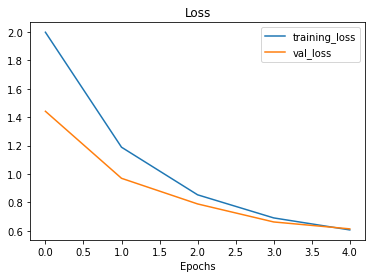

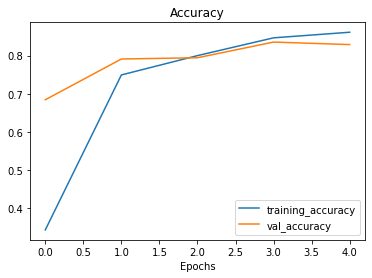

In [14]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

> 🤔 **Question:** What happens with the `tf.keras.layers.GlobalAveragePooling2D()` layer? I haven't seen it before.

The [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer transforms a 4D tensor into a 2D tensor by averaging the values across the inner-axes.

The previous sentence is a bit of a mouthful, so let's see an example.

In [15]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


You can see the `tf.keras.layers.GlobalAveragePooling2D()` layer condensed the input tensor from shape `(1, 4, 4, 3)` to `(1, 3)`. It did so by averaging the `input_tensor` across the middle two axes.

We can replicate this operation using the `tf.reduce_mean()` operation and specifying the appropriate axes.

In [16]:
# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

Doing this not only makes the output of the base model compatible with the input shape requirement of our output layer (`tf.keras.layers.Dense()`), it also condenses the information found by the base model into a lower dimension **feature vector**.

> 🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector** (a long tensor of numbers, in our case, this is the output of the [`tf.keras.layers.GlobalAveragePooling2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D) layer) which can then be used to extract patterns out of.

> 🛠 **Practice:** Do the same as the above cell but for [`tf.keras.layers.GlobalMaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool2D).

In [17]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]



## Running a series of transfer learning experiments

We'll run the following modelling experiments:
1. `model_1`: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. `model_2`: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. `model_3`: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4`: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

While all of the experiments will be run on different versions of the training data, they will all be evaluated on the same test dataset, this ensures the results of each experiment are as comparable as possible.

* All experiments will be done using the `EfficientNetB0` model within the `tf.keras.applications` module.

* To make sure we're keeping track of our experiments, we'll use our `create_tensorboard_callback()` 

* We'll construct each model using the Keras Functional API and instead of implementing data augmentation in the `ImageDataGenerator` class as we have previously, we're going to build it right into the model using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module.

Let's begin by downloading the data for experiment 1, using feature extraction transfer learning on 1% of the training data with data augmentation.

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir_1_percent = "10_food_classes_1_percent/test/"

--2022-08-09 01:39:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   282MB/s    in 0.5s    

2022-08-09 01:39:28 (282 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

Alright, looks like we've only got seven images of each class, this should be a bit of a challenge for our model.

> 🔑 **Note:** As with the 10% of data subset, the 1% of images were chosen at random from the original full training dataset. The test images are the same as the ones which have previously been used. If you want to see how this data was preprocessed, check out the [Food Vision Image Preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).

Time to load our images in as `tf.data.Dataset` objects, to do so, we'll use the [`image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) method. 

In [20]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE, 
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

Previously we've used the different parameters of the `ImageDataGenerator` class to augment our training images, this time we're going to build data augmentation right into the model.

How?

Using the [`tf.keras.layers.experimental.preprocessing`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing) module and creating a dedicated data augmentation layer.

This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:
* Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
  * Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
* Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-data-augmentation-inside-a-model.png)
*Example of using data augmentation as the first layer within a model (EfficientNetB0).*

> 🤔 **Note:** At the time of writing, the preprocessing layers we're using for data augmentation are in *experimental* status within the in TensorFlow library. This means although the layers should be considered stable, the code may change slightly in a future version of TensorFlow. For more information on the other preprocessing layers avaiable and the different methods of data augmentation, check out the [Keras preprocessing layers guide](https://keras.io/guides/preprocessing_layers/) and the [TensorFlow data augmentation guide](https://www.tensorflow.org/tutorials/images/data_augmentation).

To use data augmentation right within our model we'll create a Keras Sequential model consisting of only data preprocessing layers, we can then use this Sequential model within another Functional model.

If that sounds confusing, it'll make sense once we create it in code.

The data augmentation transformations we're going to use are:
* [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomFlip) - flips image on horizontal or vertical axis.
* [RandomRotation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomRotation) - randomly rotates image by a specified amount.
* [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomZoom) - randomly zooms into an image by specified amount.
* [RandomHeight](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomHeight) - randomly shifts image height by a specified amount.
* [RandomWidth](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/RandomWidth) - randomly shifts image width by a specified amount.
* [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Rescaling) - normalizes the image pixel values to be between 0 and 1, this is worth mentioning because it is required for some image models but since we're using the `tf.keras.applications` implementation of `EfficientNetB0`, it's not required.

There are more option but these will do for now.

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  #preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
  ], name ="data_augmentation")

In [22]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

def augment_random_image(class_names, train_dir, data_augmentation):

  '''Plot 1:Original Random Image'''
  # 1. choose a random class
  target_class = random.choice(class_names) 
  # 2. create the target directory
  target_dir = train_dir + target_class 
  # 3. choose a random image from target directory
  random_image = random.choice(os.listdir(target_dir)) 
  # 4. create the choosen random image path
  random_image_path = target_dir + "/" + random_image 
  # read in the chosen target image
  img = mpimg.imread(random_image_path) 
  plt.imshow(img) # plot the target image
  plt.title(f"Original random image from class: {target_class}")
  plt.axis(False); # turn off the axes

  '''Plot 2: Augmented Random Image'''
  # Augment the image
  img_expand = tf.expand_dims(img, axis=0) # data augmentation model requires shape (None, height, width, 3)
  augmented_img = data_augmentation(img_expand)
  augmented_img_normal = tf.squeeze(augmented_img)/255. # requires normalization after augmentation
  #plot augmented image 
  plt.figure()
  plt.imshow(augmented_img_normal)
  plt.title(f"Augmented random image from class: {target_class}")
  plt.axis(False);

In [23]:
#save class names of one % data frame in an obejct 
class_names_one = train_data_1_percent.class_names
class_names_one

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

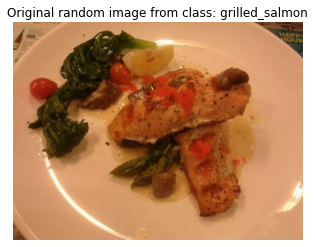

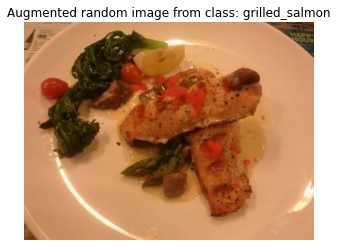

In [24]:
#view random image
augment_random_image(class_names_one, train_dir_1_percent, data_augmentation)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
#create a function that builds a model based on 
def create_model_ft(input_shape, data_augmentation_layer):
  '''
  Args: this function takes in an data input shape and a data-augmentation
        layer (pre-built using keras.Sequential) 

  Returns: transfer learning model with data augentation included in the   
            architecture 

  Steps
  1.Setup base model
  2.Create input layer
  3.Add in data augmentation Sequential model as a layer 
  4.Give base_model inputs (after augmentation) and don't train it
  5.Pool output features of base model
  6.Create output layer with probability distribution 
  7.
  '''

  # Setup base model, freezing the base model layers
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  inputs_augmented = data_augmentation_layer(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  base_model_output = base_model(inputs_augmented, training=False)

  # Pool output features of base model
  base_pooled_output = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model_output)

  # Put a dense layer on as the output
  outputs = layers.Dense(10, activation="softmax", name="output_layer")(base_pooled_output)

  # Make a model with inputs and outputs
  model = keras.Model(inputs, outputs)

  return model


In [26]:
#define create_model_ft parameters
input_shape = (224, 224, 3)
#create model 
model_1 = create_model_ft(input_shape, data_augmentation)

In [27]:
# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25* len(test_data)), # validate for less steps
                                # Track model training logs
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220809-014011
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4326 - accuracy: 0.0857 - val_loss: 2.2294 - val_accuracy: 0.1941
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1818 - accuracy: 0.1714 - val_loss: 2.1191 - val_accuracy: 0.2648
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9688 - accuracy: 0.3857 - val_loss: 2.0089 - val_accuracy: 0.3224
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.8015 - accuracy: 0.5000 - val_loss: 1.9269 - val_accuracy: 0.3668
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.7175 - accuracy: 0.5000 - val_loss: 1.8589 - val_accuracy: 0.4227


In [28]:
# Check out model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [29]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 7s 88ms/step - loss: 1.8610 - accuracy: 0.4216


[1.8609505891799927, 0.42160001397132874]

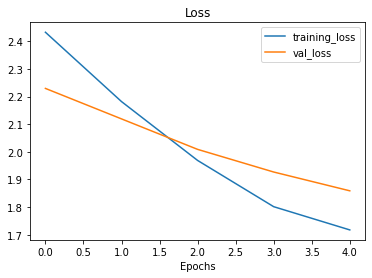

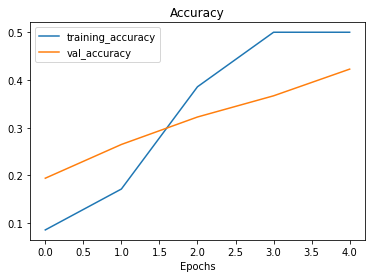

In [30]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation

In [31]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [32]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


Build data augmentation layer 

In [33]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation_m2 = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

Create model_2 using the `create_model_ft` function we created

In [34]:
# Setup the input shape to our model
input_shape = (224, 224, 3)

#create model_2
model_2 = create_model_ft(input_shape, data_augmentation_m2)

In [35]:
#Compile model_2
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
                metrics=["accuracy"])

### Creating a ModelCheckpoint callback

The [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback gives you the ability to save your model, as a whole in the [`SavedModel`](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model) format or the [weights (patterns) only](https://www.tensorflow.org/tutorials/keras/save_and_load#manually_save_weights) to a specified directory as it trains. 


* This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.


> For example, if you fit a feature extraction transfer learning model 
for 5 epochs and you check the training curves and see it was still 
improving and you want to see if fine-tuning for another 5 epochs 
could help, you can load the checkpoint, unfreeze some (or all) of 
the base model layers and then continue training.

In [36]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)



Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable `initial_epochs` and set it to 5 to use later.

We'll also add in our `checkpoint_callback` in our list of `callbacks`.

In [37]:
# Fit the model
initial_epochs = 5
history_10_percent_aug = model_2.fit(train_data_10_percent,
                                 epochs=initial_epochs,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25* len(test_data)), # validate for less steps
                                 # Track model training logs
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220809-014133
Epoch 1/5
24/24 [==============================] - 19s 549ms/step - loss: 2.0178 - accuracy: 0.3387 - val_loss: 1.4968 - val_accuracy: 0.6431
Epoch 2/5
24/24 [==============================] - 10s 411ms/step - loss: 1.3802 - accuracy: 0.6520 - val_loss: 1.0642 - val_accuracy: 0.7549
Epoch 3/5
24/24 [==============================] - 9s 358ms/step - loss: 1.0606 - accuracy: 0.7507 - val_loss: 0.8613 - val_accuracy: 0.7878
Epoch 4/5
24/24 [==============================] - 9s 375ms/step - loss: 0.9006 - accuracy: 0.7813 - val_loss: 0.7462 - val_accuracy: 0.8043
Epoch 5/5
24/24 [==============================] - 8s 336ms/step - loss: 0.8072 - accuracy: 0.7907 - val_loss: 0.6697 - val_accuracy: 0.8125


In [38]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 72ms/step - loss: 0.6991 - accuracy: 0.8072


[0.6991351842880249, 0.807200014591217]

In [39]:
#compare to model 0
model_0.evaluate(test_data)

79/79 [==============================] - 8s 92ms/step - loss: 0.6189 - accuracy: 0.8344


[0.6189411878585815, 0.8343999981880188]

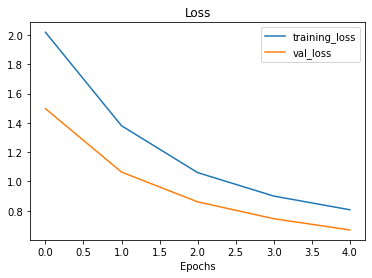

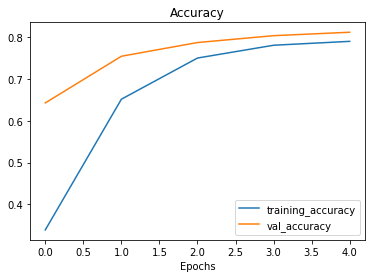

In [40]:
# Plot model loss curves
plot_loss_curves(history_10_percent_aug)

In [44]:
checkpoint_path

'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

In [47]:
#save model_2 weights in specified path 
model_2.save_weights(checkpoint_path)

In [48]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [49]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6991 - accuracy: 0.8072


In [50]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

If the above cell doesn't output `True`, it's because the numbers are close but not the *exact* same (due to how computers store numbers with degrees of precision).

However, they should be *very* close...

In [51]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [52]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/05-fine-tuning-an-efficientnet-model.png)
*High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.*

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

> 🔑 **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out [Keras' guide on Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/).


In [53]:
# Layers in loaded model
model_2.layers

In [54]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


Looking good. We've got an input layer, a Sequential layer (the data augmentation model), a Functional layer (EfficientNetB0), a pooling layer and a Dense layer (the output layer).

How about a summary?

In [55]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

Alright, it looks like all of the layers in the `efficientnetb0` layer are frozen. We can confirm this using the `trainable_variables` attribute.

In [56]:
# How many layers are trainable in our base model?
print(len(model_2.layers[2].trainable_variables)) # layer at index 2 is the EfficientNetB0 layer (the base model)

0


This is the same as our base model.

In [57]:
print(len(base_model.trainable_variables))

0


We can even check layer by layer to see if the they're trainable.

In [58]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

> 🤔 **Question:** How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.

> 📖 **Resource:** The [ULMFiT (Universal Language Model Fine-tuning for Text Classification) paper](https://arxiv.org/abs/1801.06146) has a great series of experiments on fine-tuning models.

To begin fine-tuning, we'll unfreeze the entire base model by setting its `trainable` attribute to `True`. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their `trainable` attribute to `False`. Finally, we'll recompile the model.

> I cann't use the `create_model_ft` functionality due to the need to change the `base_model` trainable parameter to True for the following lessons, so I have to create a model_2x outside this function


In [63]:
  # Setup base model, freezing the base model layers
  base_model = tf.keras.applications.EfficientNetB0(include_top=False)
  base_model.trainable = False

  # Setup the input shape to our model
  input_shape = (224, 224, 3)

  # Create input layer
  inputs = layers.Input(shape=input_shape, name="input_layer")

  # Add in data augmentation Sequential model as a layer
  inputs_augmented = data_augmentation_m2(inputs)

  # Give base_model inputs (after augmentation) and don't train it
  base_model_output = base_model(inputs_augmented, training=False)

  # Pool output features of base model
  base_pooled_output = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(base_model_output)

  # Put a dense layer on as the output
  outputs = layers.Dense(10, activation="softmax", name="output_layer")(base_pooled_output)

  # Make a model with inputs and outputs
  model_2x = keras.Model(inputs, outputs)

In [64]:
#Compile model_2x
model_2x.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # use Adam optimizer with base learning rate
                metrics=["accuracy"])
# Fit the model
initial_epochs = 5
history_10_percent_aug_2x = model_2x.fit(train_data_10_percent,
                                         epochs=initial_epochs,
                                         steps_per_epoch=len(train_data_10_percent),
                                         validation_data=test_data,
                                         validation_steps=int(0.25* len(test_data)), # validate for less steps
                                           # Track model training logs
                                         callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220809-022132
Epoch 1/5
24/24 [==============================] - 14s 346ms/step - loss: 1.9980 - accuracy: 0.3600 - val_loss: 1.4810 - val_accuracy: 0.6431
Epoch 2/5
24/24 [==============================] - 8s 314ms/step - loss: 1.3638 - accuracy: 0.6720 - val_loss: 1.0730 - val_accuracy: 0.7500
Epoch 3/5
24/24 [==============================] - 9s 328ms/step - loss: 1.0758 - accuracy: 0.7453 - val_loss: 0.8820 - val_accuracy: 0.7796
Epoch 4/5
24/24 [==============================] - 9s 373ms/step - loss: 0.9267 - accuracy: 0.7653 - val_loss: 0.7610 - val_accuracy: 0.8092
Epoch 5/5
24/24 [==============================] - 9s 346ms/step - loss: 0.8338 - accuracy: 0.7840 - val_loss: 0.6978 - val_accuracy: 0.8141


In [105]:
# Evaluate on the test data
results_10_percent_data_aug_2x = model_2x.evaluate(test_data)
results_10_percent_data_aug_2x

79/79 [==============================] - 7s 71ms/step - loss: 0.7119 - accuracy: 0.8140


[0.7118868231773376, 0.8140000104904175]

In [65]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2x.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                 metrics=["accuracy"])

In [70]:
#save model_2x weights in specified path 
model_2x.save_weights(checkpoint_path)

In [71]:
# Load in saved model weights and evaluate model
model_2x.load_weights(checkpoint_path)

In [103]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results_2x = model_2x.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.7119 - accuracy: 0.8140


In [106]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug_2x == loaded_weights_model_results_2x

False

In [107]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug_2x), np.array(loaded_weights_model_results_2x))

array([ True,  True])

Wonderful, now let's check which layers of the pretrained model are trainable.

In [73]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha


> 🤔 **Question:** Why did we recompile the model?

Every time you make a change to your models, you need to recompile them.

In our case, we're using the exact same loss, optimizer and metrics as before, except this time the learning rate for our optimizer will be 10x smaller than before (0.0001 instead of Adam's default of 0.001).

We do this so the model doesn't try to overwrite the existing weights in the pretrained model too fast. In other words, we want learning to be more gradual.

> 🔑 **Note:** There's no set standard for setting the learning rate during fine-tuning, though reductions of [2.6x-10x+ seem to work well in practice](https://arxiv.org/abs/1801.06146).

How many trainable variables do we have now?

In [74]:
print(len(model_2x.trainable_variables))

12


Wonderful, it looks like our model has a total of 10 trainable variables, the last 10 layers of the base model and the weight and bias parameters of the Dense output layer.

Time to fine-tune!

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the `initial_epoch` parameter of the [`fit()`](https://keras.rstudio.com/reference/fit.html) method. We'll pass it the last epoch of the previous model's training history (`history_10_percent_data_aug.epoch[-1]`).

In [75]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2x.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_aug_2x.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220809-022949
Epoch 5/10
24/24 [==============================] - 16s 391ms/step - loss: 0.7177 - accuracy: 0.7800 - val_loss: 0.5567 - val_accuracy: 0.8125
Epoch 6/10
24/24 [==============================] - 8s 326ms/step - loss: 0.5745 - accuracy: 0.8187 - val_loss: 0.5324 - val_accuracy: 0.8174
Epoch 7/10
24/24 [==============================] - 7s 264ms/step - loss: 0.5012 - accuracy: 0.8587 - val_loss: 0.5367 - val_accuracy: 0.8141
Epoch 8/10
24/24 [==============================] - 9s 355ms/step - loss: 0.4291 - accuracy: 0.8827 - val_loss: 0.5077 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 8s 302ms/step - loss: 0.4135 - accuracy: 0.8667 - val_loss: 0.5032 - val_accuracy: 0.8257
Epoch 10/10
24/24 [==============================] - 9s 331ms/step - loss: 0.3835 - accuracy: 0.8853 - val_loss: 0.4893 - val_accuracy: 0.8322


> 🔑 **Note:** Fine-tuning usually takes far longer per epoch than feature extraction (due to updating more weights throughout a network).

Ho ho, looks like our model has gained a few percentage points of accuracy! Let's evalaute it.

In [76]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_2x.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.5262 - accuracy: 0.8276


Remember, the results from evaluating the model might be slightly different to the outputs from training since during training we only evaluate on 25% of the test data.

Alright, we need a way to evaluate our model's performance before and after fine-tuning. How about we write a function to compare the before and after?

In [85]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Get post fine-tuning history measurements
    new_acc = new_history.history["accuracy"]
    new_loss = new_history.history["loss"]

    new_val_acc = new_history.history["val_accuracy"]
    new_val_loss = new_history.history["val_loss"]

    # Combine original history with post fine-tuning history
    total_acc = acc + new_acc
    total_loss = loss + new_loss

    total_val_acc = val_acc + new_val_acc
    total_val_loss = val_loss + new_val_loss

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy', color="coral")
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning', color='black') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss', color='coral')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning', color='black') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

This is where saving the history variables of our model training comes in handy. Let's see what happened after fine-tuning the last 10 layers of our model.

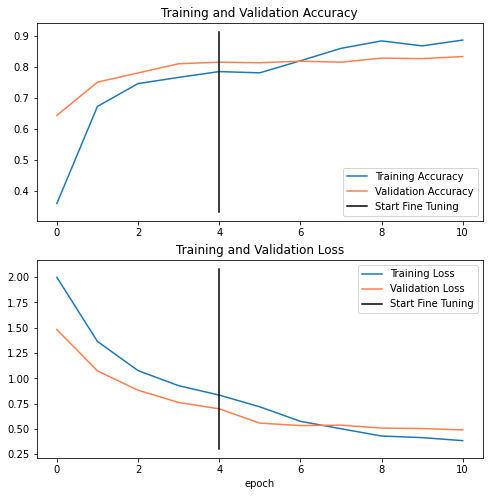

In [86]:
compare_historys(original_history=history_10_percent_aug_2x, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

Alright, alright, seems like the curves are heading in the right direction after fine-tuning. But remember, it should be noted that fine-tuning usually works best with larger amounts of data.

## Model 4: Fine-tuning an existing model all of the data

Enough talk about how fine-tuning a model usually works with more data, let's try it out.

We'll start by downloading the full version of our 10 food classes dataset.



In [87]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2022-08-09 02:53:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  82.6MB/s    in 6.3s    

2022-08-09 02:53:13 (78.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [88]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

And now we'll turn the images into tensors datasets.

In [89]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [90]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2x.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.5262 - accuracy: 0.8276


[0.526237964630127, 0.8276000022888184]

In [91]:
results_fine_tune_10_percent

[0.5262378454208374, 0.8276000022888184]

In [92]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2x.load_weights(checkpoint_path) # revert model back to saved weights

In [94]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2x.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.7119 - accuracy: 0.8140


[0.7118867039680481, 0.8140000104904175]

In [108]:
# Check to see if the above two results are the same (they should be)
results_10_percent_data_aug_2x

[0.7118868231773376, 0.8140000104904175]

Alright, the previous steps might seem quite confusing but all we've done is:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using `ModelCheckpoint`.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [96]:
# Check which layers are tuneable in the whole model
for layer_number, layer in enumerate(model_2x.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


Can we get a little more specific?

In [97]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [110]:
# Compile
model_2x.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

Alright, time to fine-tune on all of the data!

In [111]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2x.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_aug_2x.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220809-030928
Epoch 5/10
235/235 [==============================] - 55s 210ms/step - loss: 0.7434 - accuracy: 0.7633 - val_loss: 0.3922 - val_accuracy: 0.8717
Epoch 6/10
235/235 [==============================] - 45s 191ms/step - loss: 0.6071 - accuracy: 0.8020 - val_loss: 0.3978 - val_accuracy: 0.8618
Epoch 7/10
235/235 [==============================] - 42s 176ms/step - loss: 0.5350 - accuracy: 0.8261 - val_loss: 0.3253 - val_accuracy: 0.8766
Epoch 8/10
235/235 [==============================] - 40s 170ms/step - loss: 0.4898 - accuracy: 0.8411 - val_loss: 0.3372 - val_accuracy: 0.8849
Epoch 9/10
235/235 [==============================] - 39s 163ms/step - loss: 0.4559 - accuracy: 0.8561 - val_loss: 0.3280 - val_accuracy: 0.8783
Epoch 10/10
235/235 [==============================] - 35s 148ms/step - loss: 0.4211 - accuracy: 0.8619 - val_loss: 0.3079 - val_accuracy: 0.8882


> 🔑 **Note:** Training took longer per epoch, but that makes sense because we're using 10x more training data than before.

Let's evaluate on all of the test data.

In [112]:
results_fine_tune_full_data = model_2x.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 7s 75ms/step - loss: 0.3263 - accuracy: 0.8912


[0.3262966573238373, 0.8912000060081482]

Nice! It looks like fine-tuning with all of the data has given our model a boost, how do the training curves look?

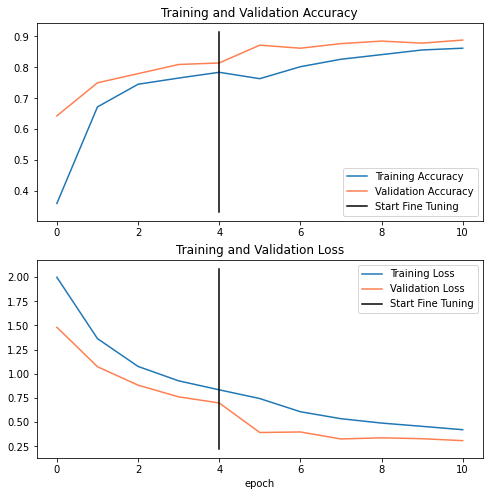

In [113]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_aug_2x,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

Looks like that extra data helped! Those curves are looking great. And if we trained for longer, they might even keep improving.

## Viewing our experiment data on TensorBoard

Right now our experimental results are scattered all throughout our notebook. If we want to share them with someone, they'd be getting a bunch of different graphs and metrics... not a fun time.

But guess what?

Thanks to the TensorBoard callback we made with our helper function `create_tensorflow_callback()`, we've been tracking our modelling experiments the whole time.

How about we upload them to TensorBoard.dev and check them out?

We can do with the `tensorboard dev upload` command and passing it the directory where our experiments have been logged.

> 🔑 **Note:** Remember, whatever you upload to TensorBoard.dev becomes public. If there are training logs you don't want to share, don't upload them.

In [116]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir /content/transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/QTYU9qfWQ4Kl9OZYPTKEQg/

[2022-08-09T03:24:17] Started scanning logdir.
[2022-08-09T03:24:28] Total uploaded: 192 scalars, 0 tensors, 6 binary objects (5.0 MB)
[2022-08-09T03:24:28] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/QTYU9qfWQ4Kl9OZYPTKEQg/


Once we've uploaded the results to TensorBoard.dev we get a shareable link we can use to view and compare our experiments and share our results with others if needed.

You can view the original versions of the experiments we ran in this notebook here: https://tensorboard.dev/experiment/2O76kw3PQbKl0lByfg5B4w/

> 🤔 **Question:** Which model performed the best? Why do you think this is? How did fine-tuning go?

To find all of your previous TensorBoard.dev experiments using the command `tensorboard dev list`.

In [117]:
# View previous experiments
!tensorboard dev list

https://tensorboard.dev/experiment/QTYU9qfWQ4Kl9OZYPTKEQg/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   QTYU9qfWQ4Kl9OZYPTKEQg
	Created              2022-08-09 03:24:17 (3 minutes ago)
	Updated              2022-08-09 03:24:28 (3 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              192
	Tensor bytes         0
	Binary object bytes  5192368
https://tensorboard.dev/experiment/zCW4adLnQzKfR7Kv7Yb8Rw/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   zCW4adLnQzKfR7Kv7Yb8Rw
	Created              2022-08-09 03:21:28 (6 minutes ago)
	Updated              2022-08-09 03:21:39 (6 minutes ago)
	Runs                 12
	Tags                 5
	Scalars              192
	Tensor bytes 

And if you want to remove a previous experiment (and delete it from public viewing) you can use the command:

```
tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID_TO_DELETE]```

In [120]:
# Remove previous experiments
!tensorboard dev delete --experiment_id QTYU9qfWQ4Kl9OZYPTKEQg
!tensorboard dev delete --experiment_id zCW4adLnQzKfR7Kv7Yb8Rw

Deleted experiment QTYU9qfWQ4Kl9OZYPTKEQg.
Deleted experiment zCW4adLnQzKfR7Kv7Yb8Rw.


## 🛠 Exercises

1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.
2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using [`tf.keras.applications.EfficientNetB0`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) as the base model. Use the [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback to save the weights to file.
3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

## 📖 Extra-curriculum

* Read the [documentation on data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) in TensorFlow.
* Read the [ULMFit paper](https://arxiv.org/abs/1801.06146) (technical) for an introduction to the concept of freezing and unfreezing different layers.
* Read up on learning rate scheduling (there's a [TensorFlow callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) for this), how could this influence our model training?
  * If you're training for longer, you probably want to reduce the learning rate as you go... the closer you get to the bottom of the hill, the smaller steps you want to take. Imagine it like finding a coin at the bottom of your couch. In the beginning your arm movements are going to be large and the closer you get, the smaller your movements become.